In [1]:
import json
import os
import shutil
import warnings
from collections import defaultdict
from datetime import datetime
from os.path import exists

In [2]:
import gensim.parsing.preprocessing as gsp
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from nltk import WordNetLemmatizer, PorterStemmer
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from stackapi import StackAPI
from wordcloud import WordCloud

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Add a key if you want to download 50k questions, otherwise it will be 2500 questions.
os.environ['SITE_API_KEY'] = ""

STACKAPI CONFIGURATION

In [5]:
if os.getenv("SITE_API_KEY") == "":
    SITE = StackAPI('stackoverflow')
    # 25 = limit with default of 100 results per page and no api key
    SITE.max_pages = 25
else:
    SITE = StackAPI('stackoverflow', key=os.getenv("SITE_API_KEY"))
    # To get 50k results
    SITE.max_pages = 500

MISC CONFIGURATION

In [6]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

PATHS

In [7]:
# All other notebooks are using this cached questions, run this one at least once before the others.
CACHED_QUESTIONS_FILE = '../cached_questions.json'

NLTK PACKAGES

In [8]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/xavier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/xavier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

NLTK OBJECTS

In [9]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [10]:
def load_cached_questions():
    """Load questions from the cache file."""
    with open(CACHED_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [11]:
def cache_questions():
    """Download and cache the questions in a file."""
    # https://stackapi.readthedocs.io/en/latest/user/complex.html
    questions = SITE.fetch('questions',
                           fromdate=datetime(2010, 1, 1),
                           todate=datetime(2024, 8, 11),
                           min=50,
                           sort='votes',
                           filter='withbody',
                           # tagged='python'
                           )
    extracted_questions = questions['items']
    
    trimmed_questions = [{
        "body": question['body'],
        "creation_date": question['creation_date'],
        "score": question['score'],
        "tags": question['tags'],
        "title": question['title']
    } for question in extracted_questions]
    
    with open(CACHED_QUESTIONS_FILE, 'w', encoding='utf-8') as f:
        json.dump(trimmed_questions, f, ensure_ascii=False, indent=4)

In [12]:
def extract_and_clean_text(question: dict):
    """Create a new 'text' field for each question containing the cleaned, tokenized and lemmatized title + body."""
    title = question['title']
    body = question['body']
    text = f"{title} {body}"
    for filter in [gsp.strip_tags,
                   gsp.strip_punctuation,
                   gsp.strip_multiple_whitespaces,
                   gsp.strip_numeric,
                   gsp.remove_stopwords,
                   gsp.strip_short,
                   gsp.lower_to_unicode]:
        text = filter(text)
    tokenized_text = nltk.tokenize.word_tokenize(text)

    # words_stemmed = (stemmer.stem(w) for w in words_without_short_words)
    words_lemmatized = [lemmatizer.lemmatize(w) for w in tokenized_text]
    question['text'] = " ".join(words_lemmatized)

    # bigrams = nltk.bigrams(tokenized_text)
    # question['bigrams'] = [' '.join(bigram) for bigram in bigrams]

    # trigrams = nltk.trigrams(tokenized_text)
    # question['trigrams'] = [' '.join(trigram) for trigram in trigrams]
    return question

In [13]:
def display_length_of_body_and_title(questions):
    """Display the distribution of the length of the bodies and titles"""
    df: DataFrame = pd.DataFrame(questions)
    
    df['body_length'] = df['body'].apply(lambda x: len(x))
    df['title_length'] = df['title'].apply(lambda x: len(x))
    
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(14, 7)
    
    sns.histplot(df['body_length'], kde=True, ax=axs[0], color='#f56900')
    axs[0].set_title('Distribution of the body length')
    
    sns.histplot(df['title_length'], kde=True, ax=axs[1], color='#f56900')
    axs[1].set_title('Distribution of the title length')
    
    plt.show()
    plt.close()
    
    boxplot = sns.boxplot(df, x="body_length")
    boxplot.set_title(f"Boxplot of the body length")
    plt.show()
    plt.close()
    
    boxplot_without_outliers = sns.boxplot(df, x="body_length", showfliers=False)
    boxplot_without_outliers.set_title(f"Boxplot of the body length without the outliers")
    plt.show()
    plt.close()

In [14]:
def visualize_word_clouds(questions):
    """Visualize the word clouds of the tags and words of the bodies and the word clouds for the five most used tags"""
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3,
                          contour_color='steelblue')

    print("Displaying now the word clouds of the unique words of the dataset.\n")
    generate_words_wordcloud(questions, wordcloud)

    print("Displaying now the word clouds of the tags in the dataset.\n")
    generate_tags_wordcloud(questions, wordcloud)

    top_5_tags = get_most_used_tags(questions, 5)['tag'].values
    generate_words_wordcloud_for_five_most_used_tags(top_5_tags, questions, wordcloud)

In [15]:
def display_word_clouds(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
    plt.show()
    plt.close()

In [16]:
def generate_tags_wordcloud(questions, wordcloud):
    """Visualize the word clouds of the tags"""
    unique_tags = set([tag for question in questions for tag in question['tags']])
    joined_tags = ','.join(unique_tags)
    print(f"{len(unique_tags)} unique tags were found in the dataset.\n")
    
    cloud = wordcloud.generate(joined_tags)
    display_word_clouds(cloud)

In [17]:
def generate_words_wordcloud(questions, wordcloud):
    """Visualize the word clouds of the words of the bodies"""
    texts = [question['text'] for question in questions]
    joined_texts = ','.join(texts)
    
    cloud = wordcloud.generate(joined_texts)
    display_word_clouds(cloud)

In [18]:
def generate_words_wordcloud_for_five_most_used_tags(top_5_tags, questions, wordcloud):
    """Generate the word clouds of unique words for the five most used tags"""
    for tag in top_5_tags:
        print(f"Displaying the wordclouds of words for the tag:{tag}.\n")
        texts_for_tag = [question['text'] for question in questions if tag in question['tags']]
        joined_texts = ','.join(texts_for_tag)

        cloud = wordcloud.generate(joined_texts)
        display_word_clouds(cloud)

In [19]:
def display_most_used_tags(questions):
    """Display the 50 most used tags and their count"""
    top_50_df = get_most_used_tags(questions, 50)
    
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(14, 14)
    
    sns.barplot(x="count", y="tag", data=top_50_df, color='#f56900', ax=axs)
    plt.title('Most used tags')
    # fig.savefig(f"{RESULTS_PATH}/most_used_tags.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [20]:
def get_most_used_tags(questions, count):
    """Returns the {count} most used tags"""
    tags = defaultdict(int)
    
    for question in questions:
        for tag in question['tags']:
            tags[tag] += 1
            
    df: DataFrame = pd.DataFrame(list(tags.items()), columns=['tag', 'count'])
    df.sort_values(by='count', ascending=False, inplace=True)
    
    return df.head(count)

In [21]:
def display_number_of_words_per_tag(questions):
    """Display the number of unique and total words for the 50 most used tags"""
    words_per_tag = defaultdict(list)
    
    for question in questions:
        for tag in question['tags']:
            words_per_tag[tag] += question['text'].split(" ")
            
    tags = []
    for tag in words_per_tag.keys():
        tags.append({
            "tag": tag,
            "words": len(words_per_tag[tag]),
            "unique_words": len(list(set(words_per_tag[tag])))
        })
        
    df: DataFrame = pd.DataFrame(tags)
    df.sort_values(by='words', ascending=False, inplace=True)
    
    top_50_df = df.head(50)
    generate_plot_with_words_per_tag(top_50_df)

In [22]:
def generate_plot_with_words_per_tag(top_50_df):
    """Generate the plot with the number of unique and total words per tag"""
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(14, 14)
    
    sns.barplot(x="words", y="tag", data=top_50_df, color='#fce0cc', ax=axs)
    sns.barplot(x="unique_words", y="tag", data=top_50_df, color='#f56900', ax=axs)
    
    plt.title('Number of unique words of the top 50 tags')
    total_bar = mpatches.Patch(color='#fce0cc', label='Total')
    unique_words_bar = mpatches.Patch(color='#f56900', label='Unique words')
    fig.legend(handles=[total_bar, unique_words_bar])
    
    # fig.savefig(f"{RESULTS_PATH}/words_per_tag.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [23]:
def visualize_dimensionality_reductions(questions):
    """Display the t-SNE visualizations of the texts linked to the five most used tags using TFIDF and CV"""
    five_most_used_tags = get_most_used_tags(questions, 5)['tag']
    all_texts = [question['text'] for question in questions]
    
    tfidf_vectorizer_model = TfidfVectorizer(stop_words='english', max_features=400)
    tfidf_vectorizer_model.fit(all_texts)
    
    count_vectorizer_model = CountVectorizer(stop_words='english', max_features=400)
    count_vectorizer_model.fit(all_texts)
    
    texts_df: DataFrame = DataFrame(columns=['tag', 'tsne-x-tfidf', 'tsne-y-tfidf', 'tsne-x-cv', 'tsne-y-cv'])
    
    for tag in five_most_used_tags:
        texts_for_tag = [question['text'] for question in questions if tag in question['tags']]
        
        tsne_results_tfidf = get_tsne_results_with_model(texts_for_tag, tfidf_vectorizer_model)
        tsne_results_cv = get_tsne_results_with_model(texts_for_tag, count_vectorizer_model)
        
        for index in range(len(tsne_results_tfidf)):
            texts_df.loc[len(texts_df)] = [tag,
                                           tsne_results_tfidf[index][0], tsne_results_tfidf[index][1],
                                           tsne_results_cv[index][0], tsne_results_cv[index][1]]
            
    create_tsne_visualization_for_model(texts_df, "tfidf")
    create_tsne_visualization_for_model(texts_df, "cv")

In [24]:
def create_tsne_visualization_for_model(texts_df: DataFrame, model_type: str) -> None:
    """Create the t-SNE visualization for the given model type"""
    plt.figure(figsize=(12, 10))
    ctf_plot = sns.scatterplot(texts_df,
                               x=f"tsne-x-{model_type}", y=f"tsne-y-{model_type}",
                               hue="tag", palette="bright")
    
    model_name = "TfidfVectorizer" if model_type == "tfidf" else "CountVectorizer"
    ctf_plot.set_title(f'Scatter plot of the texts linked to the five most used tags with {model_name}')
    ctf_plot.set_xlabel(f'F1')
    ctf_plot.set_ylabel(f'F2')
    ctf_plot.grid(True)
    
    # ctf_plot.get_figure().savefig(f"{RESULTS_PATH}/tsne_{model_type}.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [25]:
def get_tsne_results_with_model(texts_for_tag, model):
    """Get the t-SNE results for the given model"""
    ctf_transformed_text = model.transform(texts_for_tag)
    
    tsne_ctf = TSNE(n_components=2, perplexity=30, max_iter=2000, init='random', learning_rate=200, random_state=42)
    return tsne_ctf.fit_transform(ctf_transformed_text)

Starting analysis script.

49996 questions loaded from cache.

Texts extracted and cleaned.

Displaying the lengths of the bodies and titles.



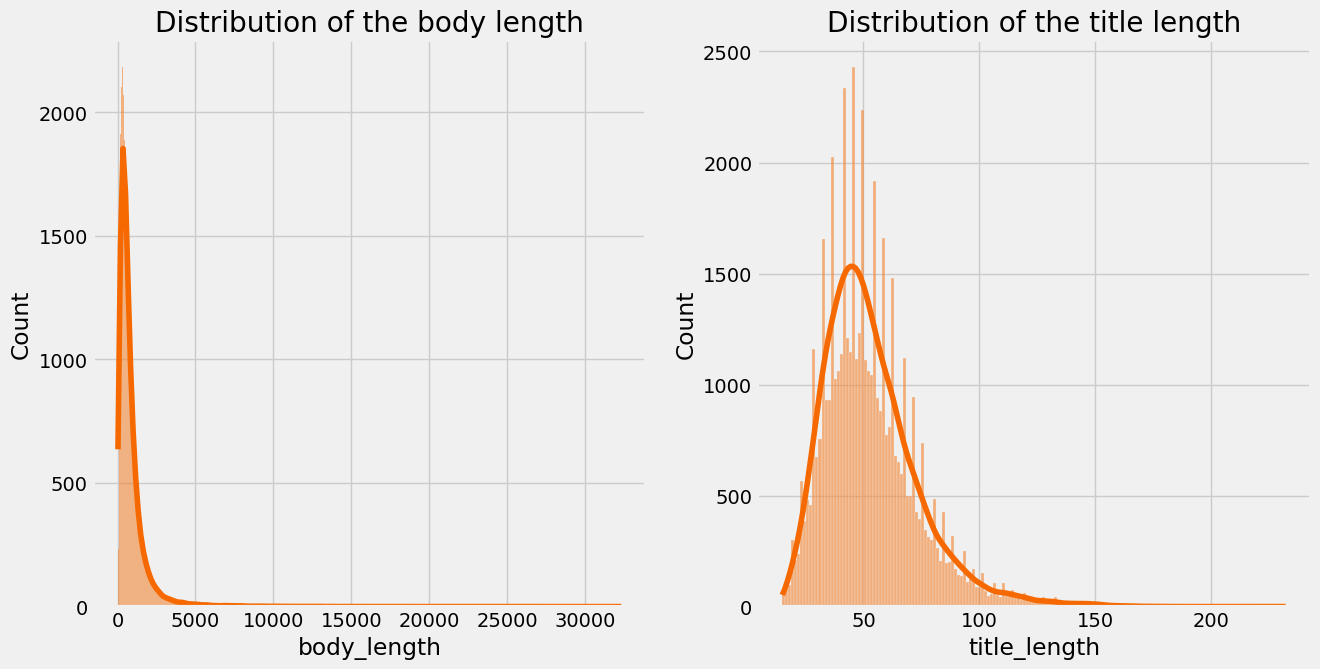

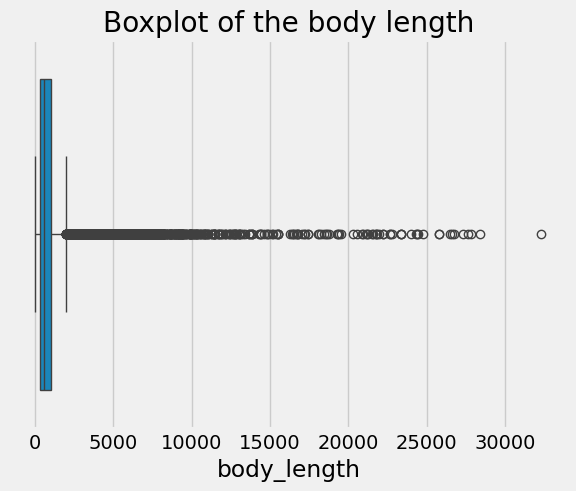

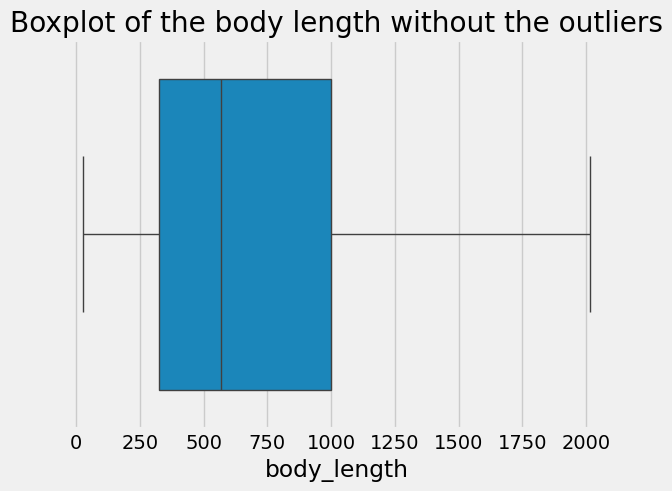

Displaying the most used tags.



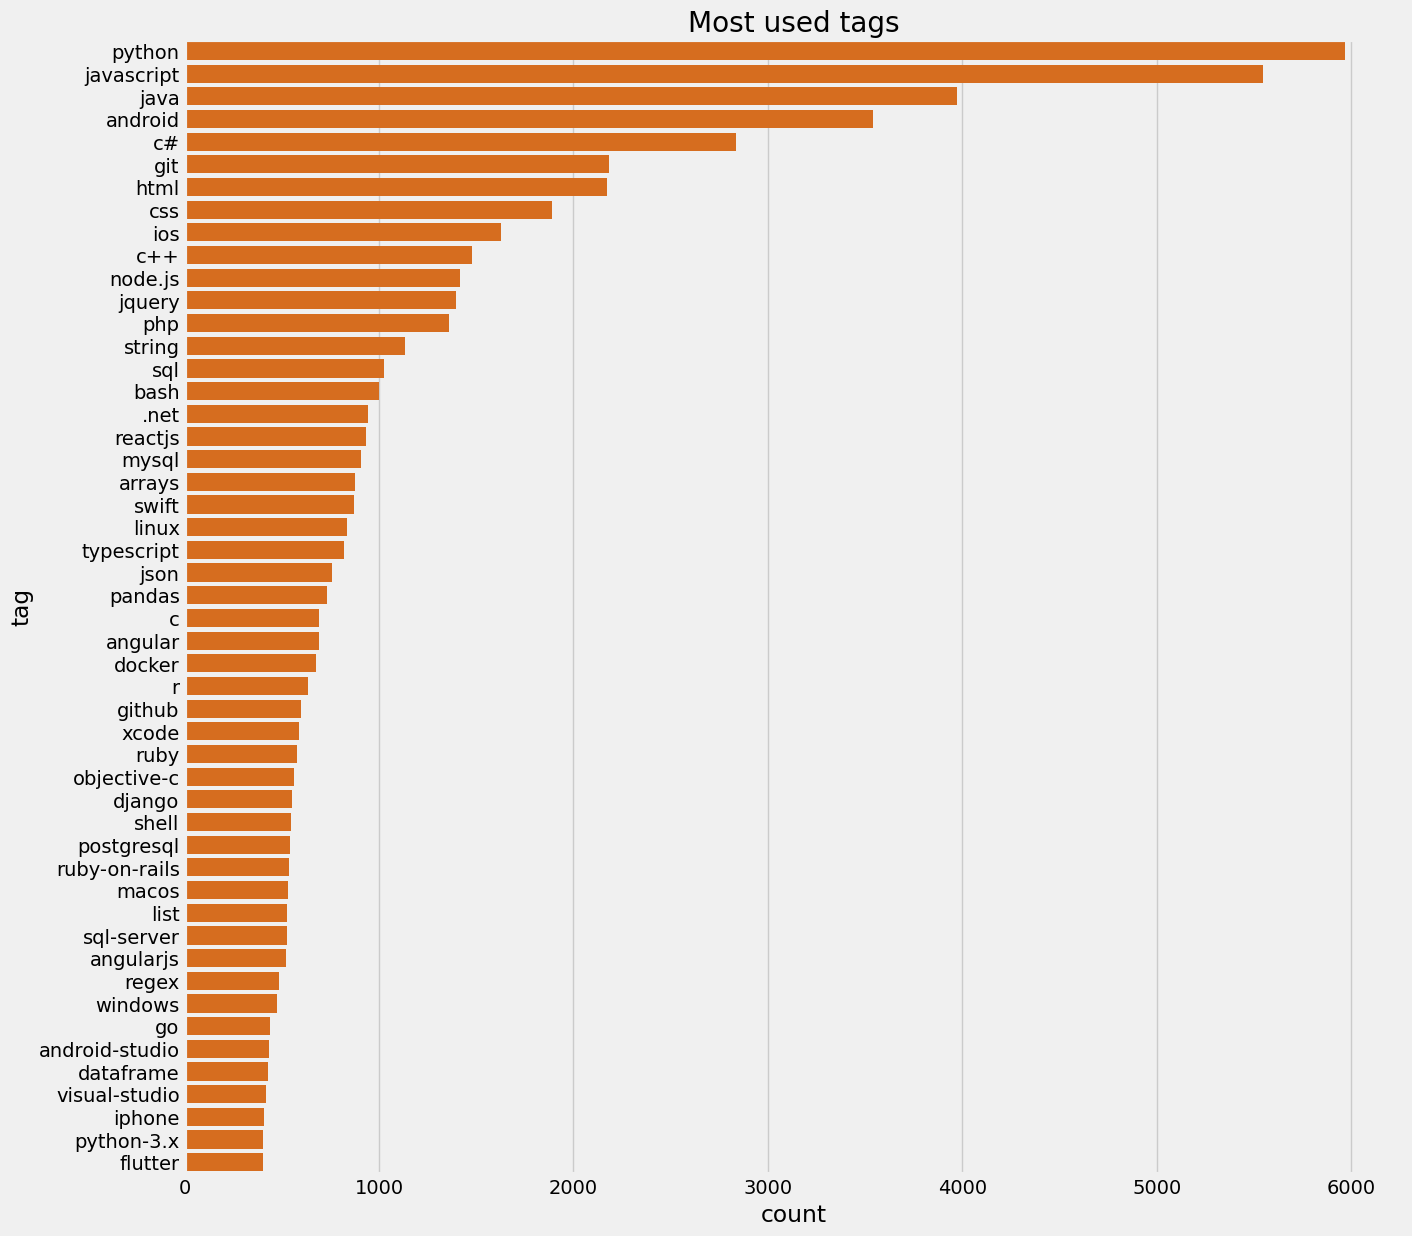

Displaying the number of words per tag.



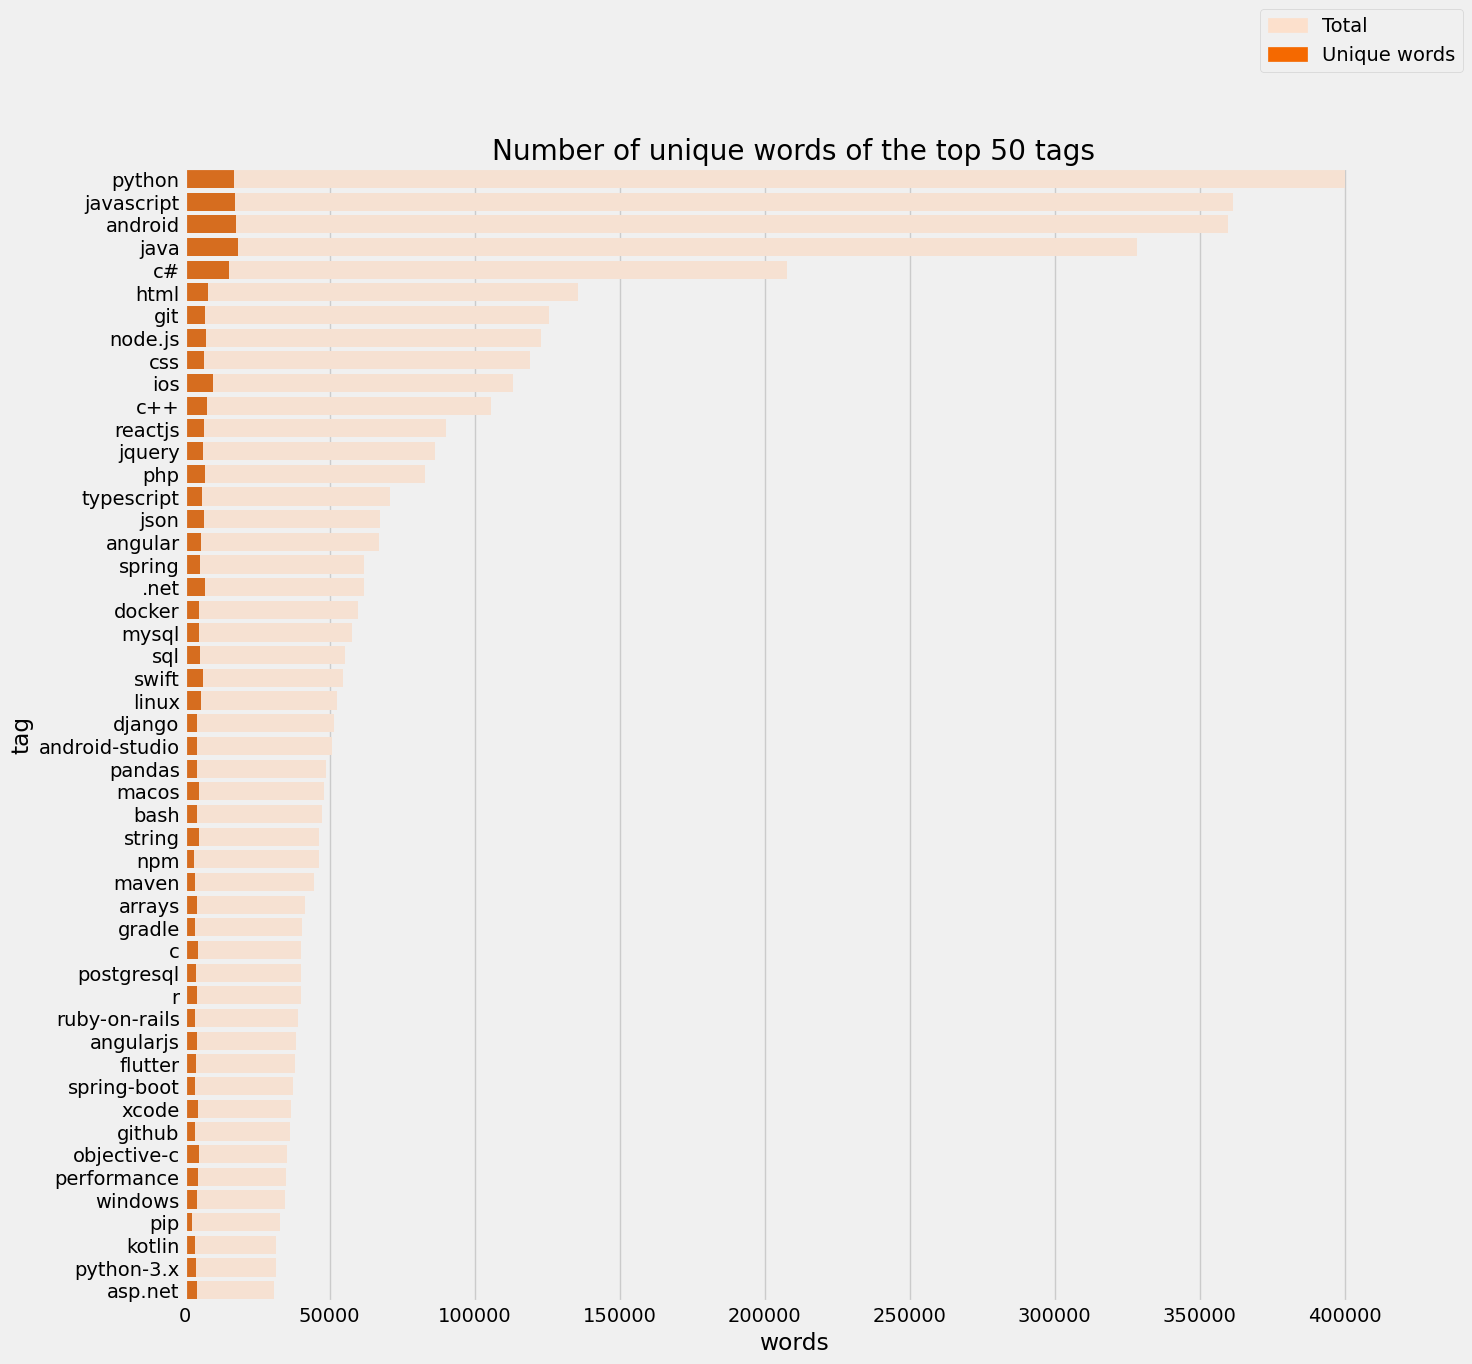

Displaying the word clouds.

Displaying now the word clouds of the unique words of the dataset.



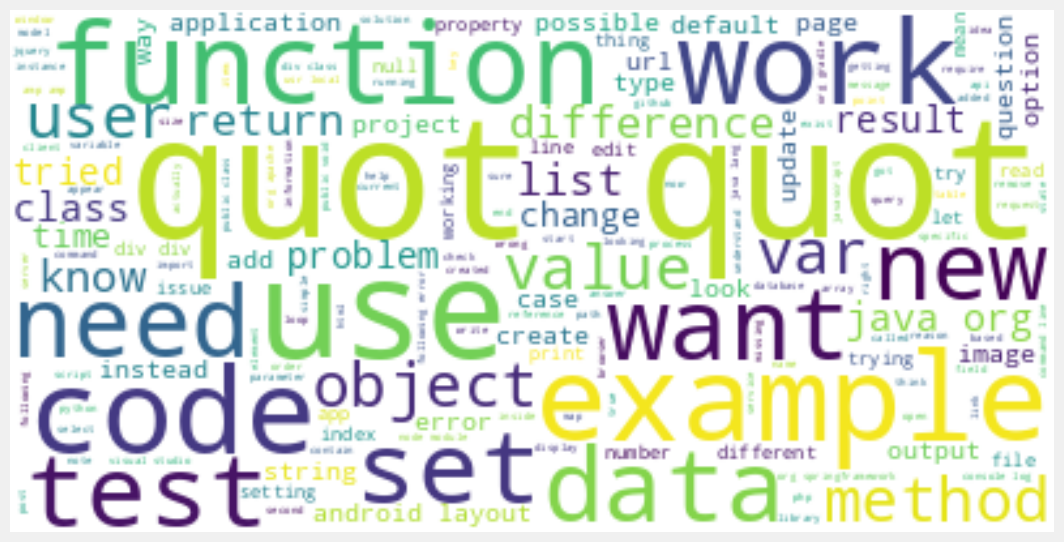

Displaying now the word clouds of the tags in the dataset.

10206 unique tags were found in the dataset.



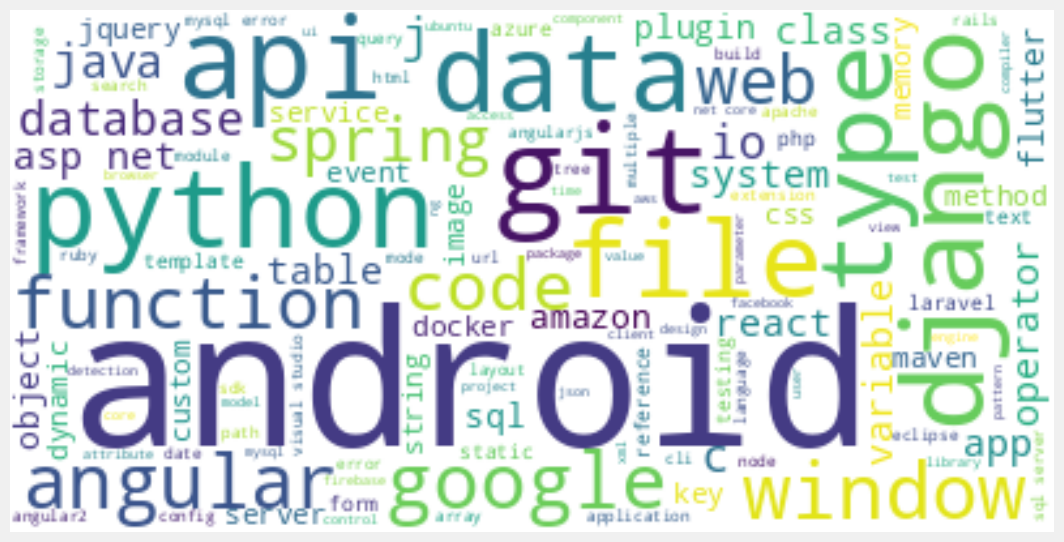

Displaying the wordclouds of words for the tag:python.



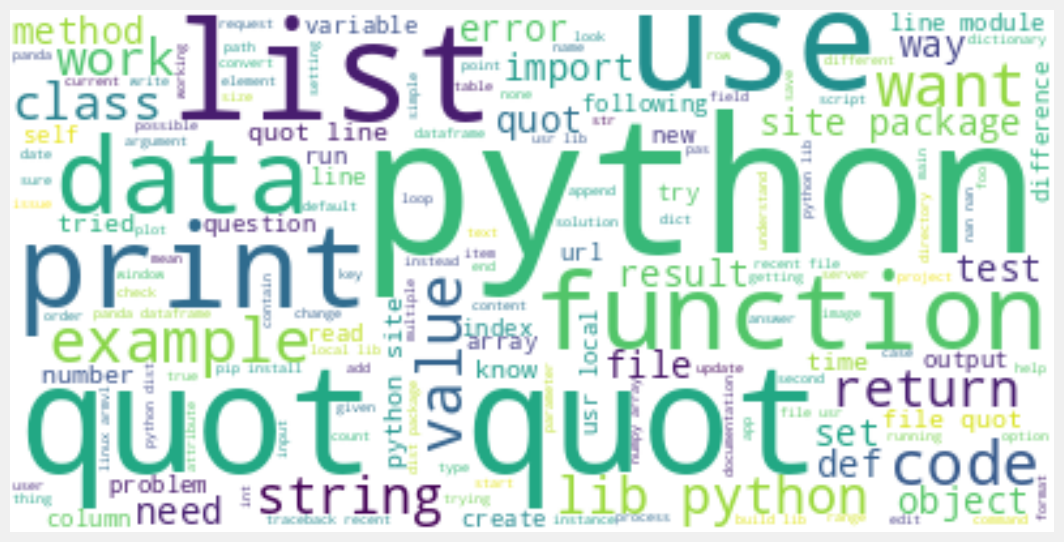

Displaying the wordclouds of words for the tag:javascript.



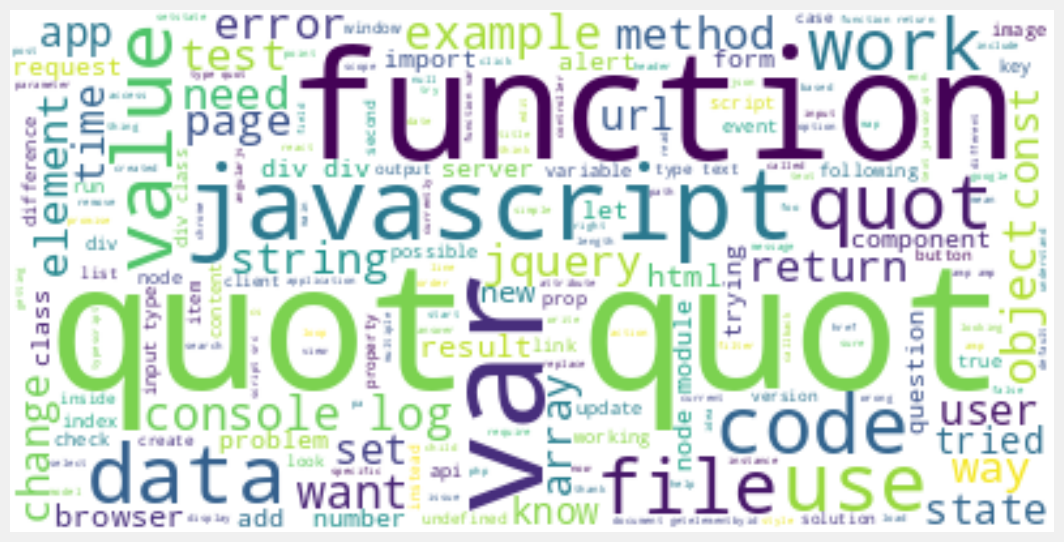

Displaying the wordclouds of words for the tag:java.



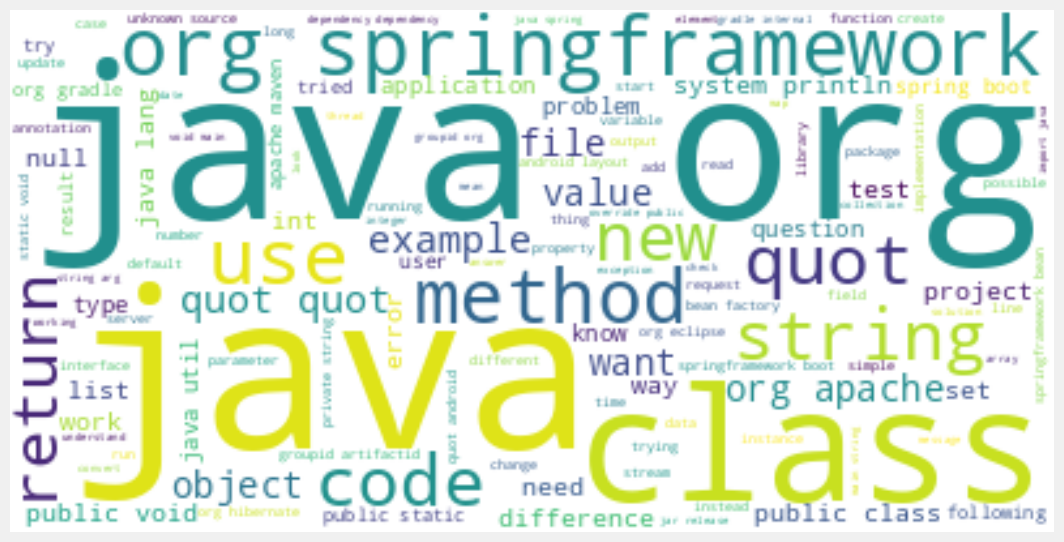

Displaying the wordclouds of words for the tag:android.



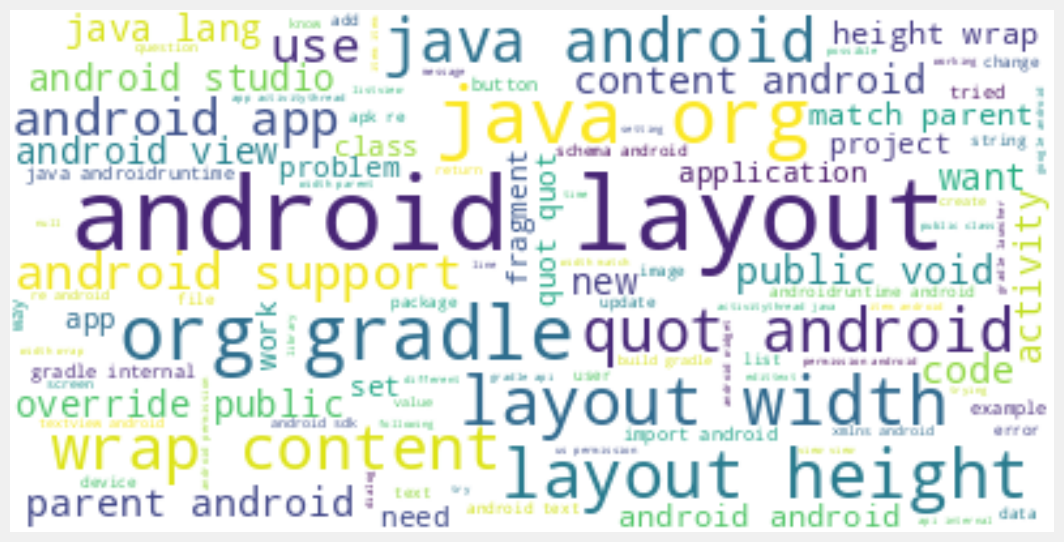

Displaying the wordclouds of words for the tag:c#.



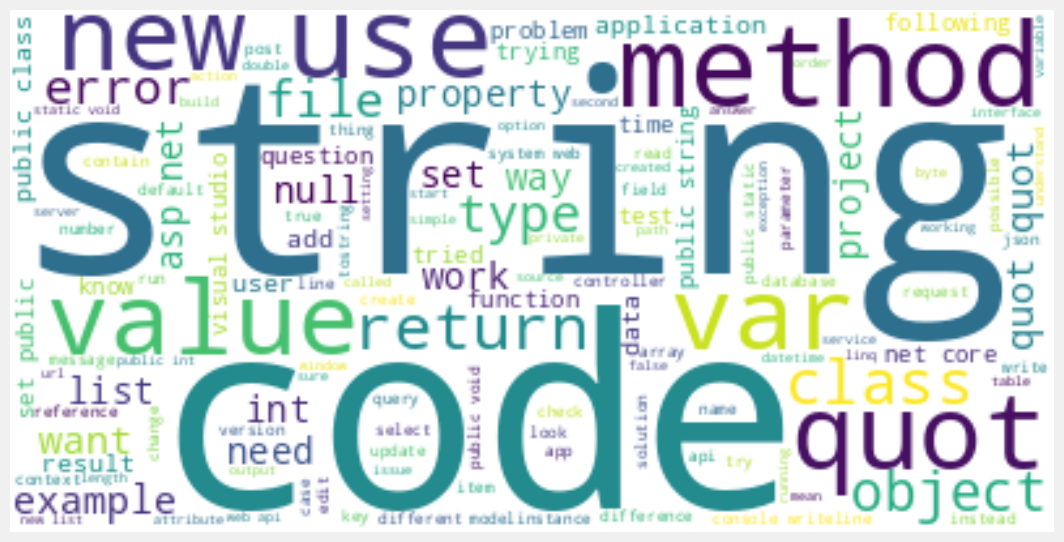

Displaying the dimensionality reduction plots.



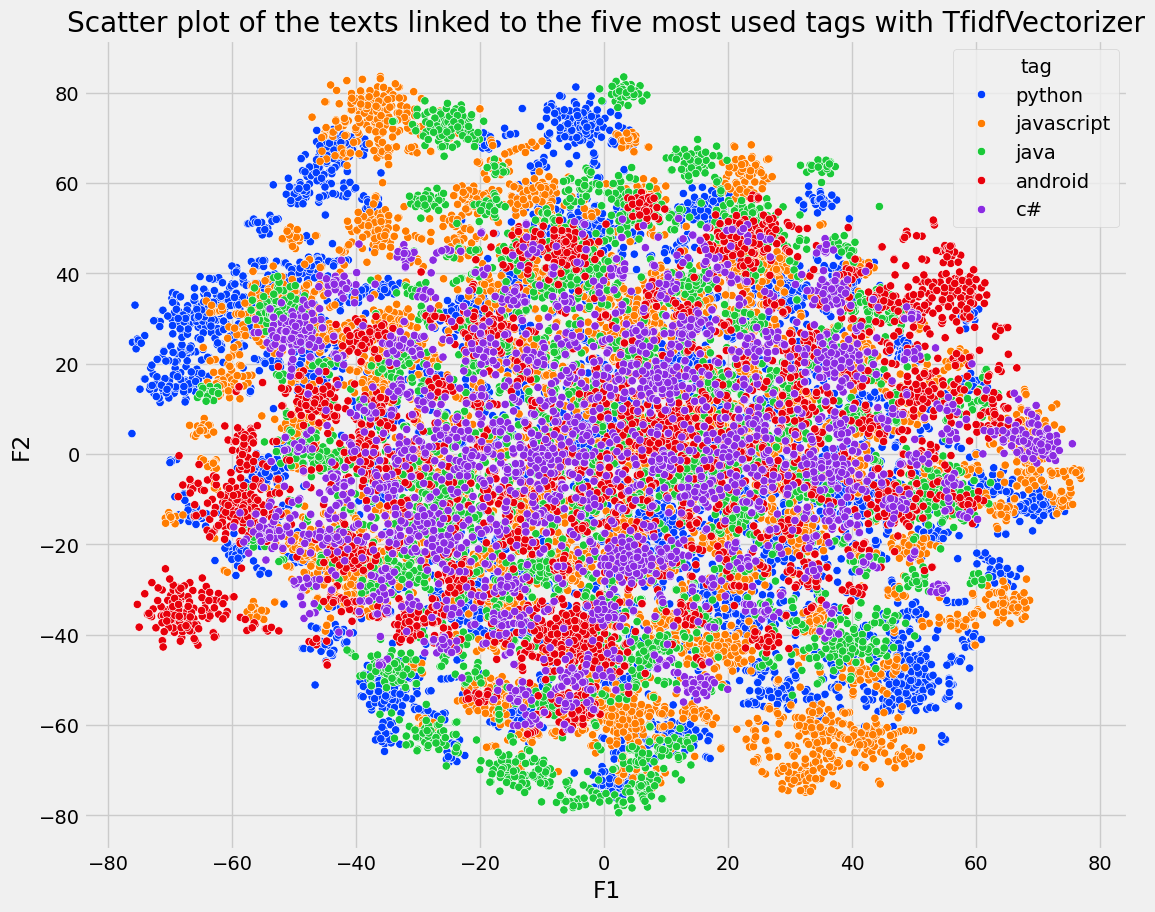

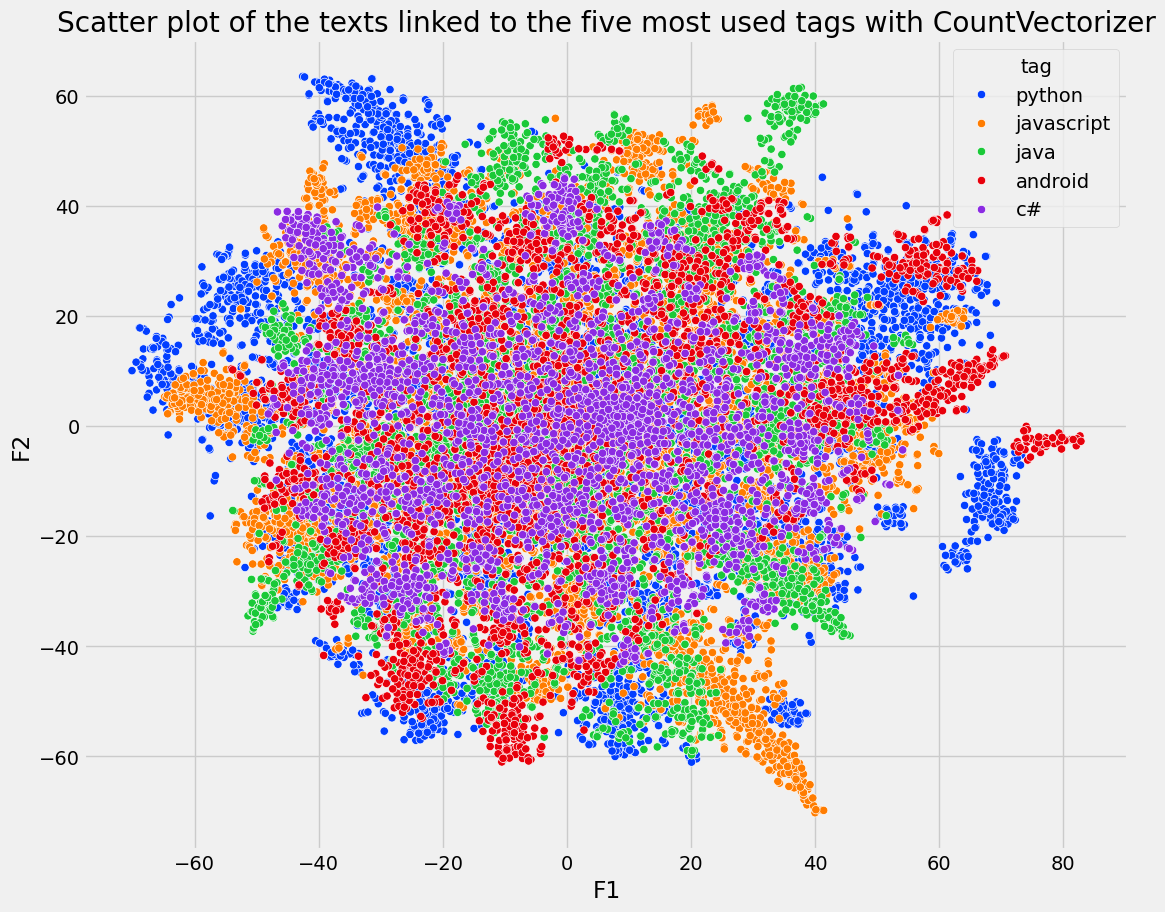

Analysis script finished.



In [26]:
print("Starting analysis script.\n")

if not exists(CACHED_QUESTIONS_FILE):
    print(f"Cached questions are missing, downloading them in {CACHED_QUESTIONS_FILE}.\n")
    cache_questions()

json_questions = load_cached_questions()

questions = [{
    "body": question['body'],
    "tags": question['tags'],
    "title": question['title']
} for question in json_questions]
print(f"{len(questions)} questions loaded from cache.\n")

# Too many false positives due to included code or technical words.
# non_english_questions = [question for question in questions if langdetect.detect(question['body']) != 'en']

cleaned_questions = list(map(extract_and_clean_text, questions))
print(f"Texts extracted and cleaned.\n")

print("Displaying the lengths of the bodies and titles.\n")
display_length_of_body_and_title(cleaned_questions)

print("Displaying the most used tags.\n")
display_most_used_tags(cleaned_questions)

print("Displaying the number of words per tag.\n")
display_number_of_words_per_tag(cleaned_questions)

print("Displaying the word clouds.\n")
visualize_word_clouds(cleaned_questions)

print("Displaying the dimensionality reduction plots.\n")
visualize_dimensionality_reductions(cleaned_questions)

print("Analysis script finished.\n")